# Bushfire Risk Data Loading and Analysis

Our task was associated with calculating the bushfire risk score of different areas throughout Sydney, based on a standardised set of bushfire variables. These variables have been sourced from a number of different datasets, which provided information such as area id, land size, population, vegetation, and dwellings to name a few. We additionally decided that general weather data surrounding different areas in Sydney could provide some interesting insights into the risk of bushfires, and have sought to integrate a data from a Web API to do so.

The key purpose of this notebook is to clean and store all the tables required for analysis into the USYD postgresql server. An attempt to answer the driving question is added to scaffold the overall problem.

This main notebook 'Assignment Notebook.ipynb' is focussed around the process of cleaning and storing a number of datasets from various sources, by making SQL queries from inside a python notebook. Some visualisations are included at the end of the notebook to show how this SQL database would then be used, but are not a final answer to the driving question (they are missing some details like axes labels that make them inappropriate for a final report).

This code will not run as USYD Data Science has shut down their SQL servers since I wrote this code last semester.


### Library Import and SQL Function Setup
First, the required libraries are imported for analyis. Connecting to the PostgreSQL Database server is conducted using the associated logins and key paths.

In [1]:
import pandas as pd
import numpy as np
from sqlalchemy import create_engine
import psycopg2
import psycopg2.extras
import json
import os


from shapely.geometry import Point, Polygon, MultiPolygon
import pandas as pd
import geopandas as gpd
from geopandas import GeoSeries, GeoDataFrame
from geoalchemy2 import Geometry, WKTElement

# creating functions required for execution of SQL commands in notebook
# pgconnect, pgexecute and pgquery functions pulled from tutorials.
data_path = "."

def pgconnect(credential_filepath, db_schema="public"):
    # please replace <your_unikey> and <your_SID> with your own details in the credentials file!
    with open(credential_filepath) as f:
        db_conn_dict = json.load(f)
        HOST       = db_conn_dict['host']
        DB_USER    = db_conn_dict['user']
        DB_PW      = db_conn_dict['password']
        DEFAULT_DB = db_conn_dict['user']

        try:
            db = create_engine('postgres+psycopg2://'+DB_USER+':'+DB_PW+'@'+HOST+'/'+DEFAULT_DB, echo=False)
            conn = db.connect()
            print('connected')
        except Exception as e:
            print("unable to connect to the database")
            print(e)
        return db,conn

credfilepath = os.path.join(data_path, "data2x01_db.json")


In [2]:


def pgexecute( conn, sqlcmd, args=None, msg='', silent=False ):
    """ utility function to execute some SQL query statement
       can take optional arguments to fill in (dictionary)
       will print out on screen the result set of the query
       error and transaction handling built-in """
    retval = False
    result_set = None

    try:
        if args is None:
            result_set = conn.execute(sqlcmd).fetchall()
        else:
            result_set = conn.execute(sqlcmd, args).fetchall()

        if silent == False: 
            print("success: " + msg)
            for record in result_set:
                print(record)
        retval = True
    except Exception as e:
        if silent == False:
            print("db read error: ")
            print(e)
    return retval

def pgquery( conn, sqlcmd, args=None, silent=False ):
    """ utility function to execute some SQL query statement
    can take optional arguments to fill in (dictionary)
    will print out on screen the result set of the query
    error and transaction handling built-in """
    retdf = pd.DataFrame()
    retval = False
    try:
        if args is None:
            retdf = pd.read_sql_query(sqlcmd,conn)
        else:
            retdf = pd.read_sql_query(sqlcmd,conn,params=args)
        if silent == False:
            print(retdf.shape)
            print(retdf.to_string())
        retval = True
    except Exception as e:
        if silent == False:
            print("db read error: ")
            print(e)
    return retval,retdf

In [31]:
# setting up connection to USYD PostgreSQL server
db,conn = pgconnect(credfilepath)

connected


Using PostgreSQL, an empty table for the neighbourhood dataset is created to prepare before importing the neighbourhoods.csv dataset. Once the dataset is imported, a function *clean_floats* is created to replace NaN values  with 0, ensure commas are dealt with, and ensure no invalid (negative) values are found. The data frame is then stored in an SQL database with *.to_sql

In [8]:
# remove table if already created
conn.execute("DROP TABLE IF EXISTS neighbourhoods")

# ensure that the schema is in place. Primary key = area_id
neighbourhood_schema = """CREATE TABLE IF NOT EXISTS neighbourhoods (
                         area_id INTEGER primary key,
                         area_name VARCHAR(50),
                         land_area FLOAT,
                         population INTEGER,
                         number_of_dwellings INTEGER,
                         number_of_businesses INTEGER,
                         median_annual_household_income INTEGER,
                         avg_monthly_rent INTEGER
                         
                   )"""
conn.execute(neighbourhood_schema)
print(db.table_names())

['spatial_ref_sys', 'organisations', 'measurementswk4', 'rfsnsw_bfpl', 'fire_file_aust', 'neighbourhoods']


### Neighbourhoods Clean and Load
To meet integrity requirements of SQL tables we need to clean up our values as in the provided csv. NaN values are set to zero, as from inspection of the dataset NaN values were recorded in regions with very low population density, supporting the inference that NaN businesses really means that not a single business is registered in the area.

In [9]:
# reading in the data from a csv file
neighbourhoods_data = pd.read_csv('Neighbourhoods.csv')

# defines our cleaning function
def clean_floats(item):
    if type(item)==float:
        
        # set all nan values to zero
        if np.isnan(item):
            return 0
        
        # test to see if any zeros or negative values exist already
        if float(item)<=0:
            print('Invalid Value Found')
        return item
    
    # removing commas from values that would not be able to support casting to a float
    if ',' in item:
        return float(item[:item.find(',')]+item[item.find(',')+1:])
    
    return float(item)

# applies our cleaning function to the relevant columns
cols = ['land_area', 'population',
       'number_of_dwellings', 'number_of_businesses',
       'median_annual_household_income', 'avg_monthly_rent']
neighbourhoods_data[cols] = neighbourhoods_data[cols].applymap(clean_floats)

# inputting data to the server
table_name = "neighbourhoods"
neighbourhoods_data.to_sql(table_name, con=conn, if_exists='append',index=False)


To gain an initial overview of the dataset, unique Area IDs and subsequent names are printed, before the Area IDs are cleaned by converting them to integers. If an ID cannot be converted to an integer, the Area ID is printed out for further analysis.

In [10]:
# uniqueness of primary key and area names
print(neighbourhoods_data['area_id'].is_unique)
print(neighbourhoods_data['area_name'].is_unique)

# testing if any of the area_id's were not castable to an integer type
for i in neighbourhoods_data['area_id']:
    try:
        int(i)
    except:
        print(i)

True
True


In [11]:
# display the full table as stored on the server
res = pd.read_sql_query('Select * from neighbourhoods', conn)
res

,area_id,area_name,land_area,population,number_of_dwellings,number_of_businesses,median_annual_household_income,avg_monthly_rent
0,102011028,Avoca Beach - Copacabana,643.8000,7590,2325,738,46996,1906
1,102011029,Box Head - MacMasters Beach,3208.6000,10986,3847,907,42621,1682
2,102011030,Calga - Kulnura,76795.1000,4841,1575,1102,42105,1182
3,102011031,Erina - Green Point,3379.3000,14237,4450,1666,43481,1595
4,102011032,Gosford - Springfield,1691.2000,19385,6373,2126,45972,1382
...,...,...,...,...,...,...,...,...
317,106011109,Cessnock Region,1570.4341,7931,3281,673,73164,1080
318,106011113,Singleton Region,4067.2349,4919,2055,698,87984,1000
319,111021218,Morisset - Cooranbong,330.5208,14959,6298,1154,58084,1260
320,114021285,Hill Top - Colo Vale,174.3752,6025,2249,400,81120,1512


### Statistical Areas


Similarly, an SQL schema is created for the other csv datasets, Statistical Areas, Business Statistics and the datasets are subsequently read into the dataset. This involved minor cleaning such as dropping duplicate rows. 

The Statistical Areas dataset was then checked so that the list of areas for analysis did not include parent regions (Manly is an acceptable area, but not the Northern Beaches).

In [9]:
# reading in the data from csv and looking at any duplicate records
statisticalareas_data = pd.read_csv('StatisticalAreas.csv')
print('Number or records by area_id:')
print(statisticalareas_data.sort_values('area_id')['area_id'].value_counts())
print('\nNon-unique Records:')
print(statisticalareas_data[statisticalareas_data['area_id'].isin([106,114,111])])

# since those records are complete copies, we can just drop the duplicates
statisticalareas_data = statisticalareas_data.drop_duplicates()

# filtering the areas so that only regions within sydney are considered
# structure of the data is tiered (Sydney > Region > Neighbourhood)

# regions whose parent id is 10 (Sydney) – logical array
sydney_regions = statisticalareas_data['parent_area_id'].isin(statisticalareas_data[statisticalareas_data['parent_area_id']==10]['area_id'])

# neighbourhoods whose parent id is a region of Sydney – logical array
sydney_neighbourhoods = statisticalareas_data['parent_area_id'].isin(statisticalareas_data[sydney_regions]['area_id'])

# final set of relevant regions
statisticalareas_data = statisticalareas_data[sydney_neighbourhoods]
statisticalareas_data

Number or records by area_id:
106          2
114          2
111          2
116011303    1
117011325    1
            ..
124011451    1
115041301    1
120011383    1
120011384    1
1            1
Name: area_id, Length: 431, dtype: int64

Non-unique Records:
     area_id                          area_name  parent_area_id
61       106        Hunter Valley exc Newcastle              11
66       111       Newcastle and Lake Macquarie              11
69       114  Southern Highlands and Shoalhaven              11
429      106        Hunter Valley exc Newcastle              11
431      111       Newcastle and Lake Macquarie              11
433      114  Southern Highlands and Shoalhaven              11


,area_id,area_name,parent_area_id
27,102011028,Avoca Beach - Copacabana,10201
28,102011029,Box Head - MacMasters Beach,10201
29,102011030,Calga - Kulnura,10201
30,102011031,Erina - Green Point,10201
31,102011032,Gosford - Springfield,10201
...,...,...,...
406,128021537,Royal National Park,12802
407,128021538,Sutherland - Kirrawee,12802
408,128021607,Engadine,12802
409,128021608,Loftus - Yarrawarrah,12802


In [13]:
# remove existing table
conn.execute("DROP TABLE IF EXISTS statisticalareas")

# set the schema with primary key area_id
statisticalareas_schema = """CREATE TABLE IF NOT EXISTS statisticalareas (
                         area_id INTEGER primary key,
                         area_name VARCHAR(50),
                         parent_area_id INTEGER
                         
                         
                         
                   )"""
conn.execute(statisticalareas_schema)
table_name = "statisticalareas"

# inputting our filtered data into the server
statisticalareas_data.to_sql(table_name, con=conn, if_exists='append',index=False)

### Business Stats
Due to the high quality of the existing data set no cleaning was required to meet SQL integrity constraints. Data was simply filtered to check the regions of entries were relevant (contained in the set of statistical areas) and then uploaded

In [14]:
# reading in the data and checking entries exist in statisticalareas
businessstats_data = pd.read_csv('BusinessStats.csv')
businessstats_data=businessstats_data[businessstats_data['area_id'].isin(statisticalareas_data['area_id'])]

In [15]:
# remove existing table
conn.execute("DROP TABLE IF EXISTS businessstats")

# set schema, with primary key area_id referencing the same attribute from statisticalareas
businessstats_schema = """CREATE TABLE IF NOT EXISTS businessstats (
                         area_id INTEGER primary key references statisticalareas(area_id),
                         area_name VARCHAR(50),
                         number_of_businesses INTEGER,
                         accommodation_and_food_services INTEGER,
                         retail_trade INTEGER,
                         agriculture_forestry_and_fishing INTEGER,
                         health_care_and_social_assistance INTEGER,
                         public_administration_and_safety INTEGER,
                         transport_postal_and_warehousing INTEGER
                         
                         
                   )"""
conn.execute(businessstats_schema)
table_name = "businessstats"

# uploading the data to the server
businessstats_data.to_sql(table_name, con=conn, if_exists='append',index=False)


### Bushfire Prone Lands

The approach to import the rfsnsw dataset is different as the dataset comes in the form of a shapefile. This shapefile is read in using gpd.read_file(). The rfsnsw_bfpl_data dataset was given a 'gid' column which ordered the dataset sequentially based on row numbers.

A function was then created to convert the create a column 'location' that converted the geometry column into a Well Known Text Markup Language for GIS functionality. The geometry column was then removed, and the rfsnw dataset columns were renamed for ease of use.

In [16]:
# reading in the data
rfsnsw_bfpl_data = gpd.read_file('RFSNSW_BFPL_small.shp')
# setting an identifier column as the row number
rfsnsw_bfpl_data['gid'] = list(range(len(rfsnsw_bfpl_data)))

# function to convert geometry objects into point elements
# that are compatible with geopandas functions
def create_wkt_point_element(geom,srid):
    return WKTElement(geom.wkt, srid)

# converting the geometric data to point elements and dropping the old column
rfsnsw_bfpl_data['location'] = rfsnsw_bfpl_data['geometry'].apply(lambda x: create_wkt_point_element(geom=x,srid = 4326))
rfsnsw_bfpl_data = rfsnsw_bfpl_data.drop(columns='geometry')

# resetting the column names
names = ['category','shape_leng','shape_area','gid','geometry']
rfsnsw_bfpl_data.columns = names




In [17]:
# remove the existing table
conn.execute("DROP TABLE IF EXISTS rfsnsw_bfpl")

# set the schema
rfsnsw_bfpl_schema = """CREATE TABLE IF NOT EXISTS rfsnsw_bfpl (
                         gid INTEGER primary key,
                         category INTEGER,
                         shape_leng FLOAT,
                         shape_area FLOAT,
                         geometry GEOMETRY(POINT,4326)
                         
                         
                         
                         
                   )"""
conn.execute(rfsnsw_bfpl_schema)
table_name = "rfsnsw_bfpl"

# uploading the data to the server – completed in a loop to 
# allow for progress updates in this computationally intensive task
import time 
start = time.perf_counter()
for i in range(4):
    rfsnsw_bfpl_data.iloc[10000*i:10000*(i+1)].to_sql(table_name, conn, if_exists='append', index=False, 
                         dtype={'geometry': Geometry('POINT', 4326)})
    
    print(10000*i,10000*(i+1))

rfsnsw_bfpl_data.iloc[10000*(i+1):].to_sql(table_name, conn, if_exists='append', index=False, 
                         dtype={'geometry': Geometry('POINT', 4326)})

finish = time.perf_counter()
print(finish-start)

0 10000
10000 20000
20000 30000
30000 40000
379.90490024909377


The RFSNSW dataset is then selected and displayed using an SQL query.

In [18]:

query = """SELECT *
             FROM rfsnsw_bfpl
            
            """
retval,retdf = pgquery(conn, query)
retdf


(45314, 5)


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



,gid,category,shape_leng,shape_area,geometry
0,0,1,0.000890,4.949777e-08,0101000020E6100000A6C14A5E9DBA6240BC28CBBA4626...
1,1,1,0.008990,1.417500e-06,0101000020E6100000B053865C6ABB6240A5762C7ED525...
2,2,1,0.011250,1.775249e-06,0101000020E61000003603591AEABA6240E4C61C6CBA25...
3,3,1,0.001096,3.735098e-08,0101000020E61000006EEAB2506BBA624081A4D314EE24...
4,4,1,0.027890,6.131269e-06,0101000020E6100000599ABD10D2B76240B1B4FAE98C22...
...,...,...,...,...,...
45309,45309,3,0.016425,1.036849e-05,0101000020E61000005BB6256965ED6240530035428999...
45310,45310,3,0.012095,9.113554e-06,0101000020E61000004F48CF6BF4EC6240922839293A99...
45311,45311,3,0.050685,8.878038e-05,0101000020E6100000022C46C14AEC6240DC2A65F53E98...
45312,45312,1,0.080835,8.330816e-05,0101000020E6100000C5641AD475F26240BE4E31512991...


### Neighbourhood Regions – SA2_2016 File
At this point it is time to import the SA2 shapefile using gpd.read_file. the gid column is created and listed based on the row number, and the columns are mapped in lowercase. The dataset is then cleaned so that none 'None' values are present, before a function to convert any polygon-type entries into MultiPolygons and returned in the Well Known Text Element markup language. This function is applied to the SA2 Geometry Data to create the 'location' column for SA2, which is then renamed to replace 'geometry'.

In [10]:
# reading in the data
sa2_2016_aust_data = gpd.read_file('SA2_2016_AUST.shp')

# setting all the columns to lower case and assigning an identifier column
sa2_2016_aust_data.columns = map(str.lower,sa2_2016_aust_data.columns)
sa2_2016_aust_data['g_id'] = list(range(len(sa2_2016_aust_data)))

# keeping only the areas that are in Sydney and have an associated polygon
sa2_2016_aust_data = sa2_2016_aust_data[sa2_2016_aust_data['sa2_main16'].map(lambda x: int(x)).isin(statisticalareas_data['area_id'])]
sa2_2016_aust_data = sa2_2016_aust_data[sa2_2016_aust_data['geometry'] != None]

# forcing all geometries to be stored as multipolygons and converting to WKTElements
def create_wkt_element(geom,srid):
    if (geom.geom_type == 'Polygon'):
        geom = MultiPolygon([geom])
    return WKTElement(geom.wkt, srid)

# performing the type conversion and fixing the columns
sa2_2016_aust_data['location'] = sa2_2016_aust_data['geometry'].apply(lambda x: create_wkt_element(geom=x,srid = 4326))
sa2_2016_aust_data = sa2_2016_aust_data.drop(columns='geometry')
sa2_2016_aust_data=sa2_2016_aust_data.rename(columns = {'location':'geometry'})



NameError: name 'gpd' is not defined

In [21]:
# examining the structure of the resulting table
sa2_2016_aust_data

,sa2_main16,sa2_5dig16,sa2_name16,sa3_code16,sa3_name16,sa4_code16,sa4_name16,gcc_code16,gcc_name16,ste_code16,ste_name16,areasqkm16,g_id,geometry
27,102011028,11028,Avoca Beach - Copacabana,10201,Gosford,102,Central Coast,1GSYD,Greater Sydney,1,New South Wales,6.4376,27,MULTIPOLYGON (((151.4137275700001 -33.46559324...
28,102011029,11029,Box Head - MacMasters Beach,10201,Gosford,102,Central Coast,1GSYD,Greater Sydney,1,New South Wales,32.0860,28,MULTIPOLYGON (((151.3539836770001 -33.49854010...
29,102011030,11030,Calga - Kulnura,10201,Gosford,102,Central Coast,1GSYD,Greater Sydney,1,New South Wales,767.9512,29,MULTIPOLYGON (((151.204595054 -33.532982995999...
30,102011031,11031,Erina - Green Point,10201,Gosford,102,Central Coast,1GSYD,Greater Sydney,1,New South Wales,33.7934,30,MULTIPOLYGON (((151.3679483220001 -33.43822416...
31,102011032,11032,Gosford - Springfield,10201,Gosford,102,Central Coast,1GSYD,Greater Sydney,1,New South Wales,16.9124,31,MULTIPOLYGON (((151.310060818 -33.426989095999...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
571,128021537,11537,Royal National Park,12802,Sutherland - Menai - Heathcote,128,Sydney - Sutherland,1GSYD,Greater Sydney,1,New South Wales,139.3336,571,MULTIPOLYGON (((151.071650994 -34.057945007999...
572,128021538,11538,Sutherland - Kirrawee,12802,Sutherland - Menai - Heathcote,128,Sydney - Sutherland,1GSYD,Greater Sydney,1,New South Wales,7.7547,572,MULTIPOLYGON (((151.05049439 -34.0200584319999...
573,128021607,11607,Engadine,12802,Sutherland - Menai - Heathcote,128,Sydney - Sutherland,1GSYD,Greater Sydney,1,New South Wales,8.9538,573,MULTIPOLYGON (((150.9956780320001 -34.05362100...
574,128021608,11608,Loftus - Yarrawarrah,12802,Sutherland - Menai - Heathcote,128,Sydney - Sutherland,1GSYD,Greater Sydney,1,New South Wales,3.8436,574,MULTIPOLYGON (((151.0395427830001 -34.04175791...


The SQL Schema is consequently created for the SA2 dataset before it is imported into the SQL database.

In [22]:
# removing existing table
conn.execute("DROP TABLE IF EXISTS sa2_2016_aust")

# setting the schema, with the corresponding column sa2_main16 referencing area_id in statisticalareas
sa2_2016_aust_schema = """CREATE TABLE IF NOT EXISTS sa2_2016_aust (
                         g_id INTEGER primary key,
                         sa2_main16 INTEGER references statisticalareas(area_id),
                         sa2_5dig16 INTEGER,
                         sa2_name16 VARCHAR(50),
                         sa3_code16 INTEGER,
                         sa3_name16 VARCHAR(50),
                         sa4_code16 INTEGER,
                         sa4_name16 VARCHAR(50),
                         gcc_code16 VARCHAR(10),
                         gcc_name16 VARCHAR(50),
                         ste_code16 INTEGER,
                         ste_name16 VARCHAR(50),
                         areasqkm16 FLOAT,
                         geometry GEOMETRY(MULTIPOLYGON,4326)
                         
                         
                         
                         
                   )"""

conn.execute(sa2_2016_aust_schema)
table_name = "sa2_2016_aust"

# uploading the data to the server with appropriate type setting
sa2_2016_aust_data.to_sql(table_name, conn, if_exists='append', index=False, 
                         dtype={'geometry': Geometry('MULTIPOLYGON', 4326)})
    
    


An index for both the RFNSW dataset as well as the SA2 dataset is created and executed for the datasets. This significantly increases the speed of otherwise very slow geometric computations.

In [23]:

index_command = "CREATE INDEX rfsnsw_bfpl_inx ON rfsnsw_bfpl USING GIST (geometry)"
conn.execute("DROP INDEX IF EXISTS rfsnsw_bfpl_inx ")
conn.execute(index_command)

index_command2 = "CREATE INDEX sa2_2016_aust_inx ON sa2_2016_aust USING GIST (geometry)"
conn.execute("DROP INDEX IF EXISTS sa2_2016_aust_inx ")
conn.execute(index_command2)




An SQL query to find the number of bushfire prone land areas contained within each neighbourhood of Sydney.

In [25]:
# counting the number of bfpl areas per neighbourhood using a basic geometric join condition
# with standard grouping and count aggregation on the gid index.
import time 
start = time.perf_counter()
query = """
SELECT SA.sa2_main16, count(R.gid) as "bfpl_areas"
FROM sa2_2016_aust SA JOIN rfsnsw_bfpl as R
    ON ST_Contains(SA.geometry,R.geometry)
    GROUP BY SA.sa2_main16

"""
retval,retdf = pgquery(conn, query);
retdf

finish = time.perf_counter()
print(finish-start)

(186, 2)
     sa2_main16  bfpl_areas
0     102011028          17
1     102011029          55
2     102011030         466
3     102011031          69
4     102011032          39
5     102011033          10
6     102011034          37
7     102011035          30
8     102011036          25
9     102011037          10
10    102011038          23
11    102011039          50
12    102011040          13
13    102011041          31
14    102011042          19
15    102011043          13
16    102021044          24
17    102021045          57
18    102021046          14
19    102021047          52
20    102021048          20
21    102021049         143
22    102021050          65
23    102021051          53
24    102021052          11
25    102021053          15
26    102021054          28
27    102021055          67
28    102021056          92
29    102021057          42
30    115011290           1
31    115011291           3
32    115011294           9
33    115011296           7
34    11501

### Heat Vulnerability
The Heat Vulnerability dataset shapefile was imported using geopandas and 'geometry' attributes are converted into WKTElements for GIS compatibility, and filtered for  Sa2_main16 area ids that are within the regions provided in the given datasets. This dataset is then imported into an SQL schema.

In [32]:
# reading in the data and transforming
heat_vulnerability_data = gpd.read_file('HVI_SA1_SUA_2016.shp')

def create_wkt_element(geom,srid):
    if (geom.geom_type == 'Polygon'):
        geom = MultiPolygon([geom])
    return WKTElement(geom.wkt, srid)

# fixing columns and returning a list of attributes in the data
heat_vulnerability_data['location'] = heat_vulnerability_data['geometry'].apply(lambda x: create_wkt_element(geom=x,srid = 4326))
heat_vulnerability_data = heat_vulnerability_data.drop(columns='geometry')
heat_vulnerability_data = heat_vulnerability_data[heat_vulnerability_data['SA2_MAIN16'].map(lambda x: int(x)).isin(statisticalareas_data['area_id'])]
heat_vulnerability_data.columns

Index(['SA1_MAIN16', 'SA1_7DIG16', 'SA2_MAIN16', 'SA2_5DIG16', 'HVI',
       'Expos_Indx', 'Sensi_Indx', 'AdapC_Indx', 'LGA', 'District', 'Region',
       'Shape_Leng', 'Shape_Area', 'location'],
      dtype='object')

In [33]:
# converting column names to lower case and displaying the data
heat_vulnerability_data.columns = heat_vulnerability_data.columns.map(lambda x: str.lower(x))
heat_vulnerability_data

,sa1_main16,sa1_7dig16,sa2_main16,sa2_5dig16,hvi,expos_indx,sensi_indx,adapc_indx,lga,district,region,shape_leng,shape_area,location
0,10201102801,1102801,102011028,11028,0,0,0,0,Central Coast,Central Coast,Central Coast,9586.400517,6.347395e+05,MULTIPOLYGON (((353394.7027477557 6296543.7405...
1,10201102802,1102802,102011028,11028,1,1,1,5,Central Coast,Central Coast,Central Coast,5866.643098,1.164470e+06,MULTIPOLYGON (((352592.7880914332 6295970.0139...
2,10201102803,1102803,102011028,11028,2,2,2,4,Central Coast,Central Coast,Central Coast,3823.948535,5.737018e+05,MULTIPOLYGON (((354047.6153278546 6295754.5792...
3,10201102804,1102804,102011028,11028,1,2,1,4,Central Coast,Central Coast,Central Coast,2551.416595,1.519174e+05,MULTIPOLYGON (((353567.2242732188 6295359.6418...
4,10201102805,1102805,102011028,11028,1,2,1,4,Central Coast,Central Coast,Central Coast,1853.598082,1.310394e+05,MULTIPOLYGON (((353115.9381537102 6295117.7073...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12727,12802160906,1160906,128021609,11609,1,1,1,5,Sutherland Shire,South,Greater Sydney,1567.528955,1.191284e+05,MULTIPOLYGON (((317575.6350276954 6231829.1680...
12728,12802160907,1160907,128021609,11609,1,1,1,5,Sutherland Shire,South,Greater Sydney,2385.294474,2.034157e+05,MULTIPOLYGON (((318769.5774877481 6232701.6356...
12729,12802160908,1160908,128021609,11609,1,2,1,5,Sutherland Shire,South,Greater Sydney,1968.079395,1.616137e+05,MULTIPOLYGON (((317665.4236142114 6232345.7845...
12730,12802160909,1160909,128021609,11609,1,1,1,5,Sutherland Shire,South,Greater Sydney,1518.261776,9.006825e+04,MULTIPOLYGON (((318342.1386450371 6231918.2936...


In [34]:
# removing existing table
conn.execute("DROP TABLE IF EXISTS heat_vulnerability")

# setting the schema according to the form of the data, with a reference to the statisticalareas area_id set
heat_vulnerability_schema = """CREATE TABLE IF NOT EXISTS heat_vulnerability (
                         
                         
                         sa1_main16 VARCHAR(50) primary key,
                         sa1_7dig16 VARCHAR(50),
                         sa2_main16 INTEGER references statisticalareas(area_id),
                         sa2_5dig16 INTEGER,
                         hvi INTEGER,
                         expos_indx INTEGER,
                         sensi_indx INTEGER,
                         adapc_indx INTEGER,
                         lga VARCHAR(50),
                         district VARCHAR(50),
                         region VARCHAR(50),
                         shape_leng FLOAT,
                         shape_area FLOAT,
                         location GEOMETRY(MULTIPOLYGON,4326)
                         
                         
                         
                         
                   )"""

conn.execute(heat_vulnerability_schema)
table_name = "heat_vulnerability"

# uploading to the postgresql server
heat_vulnerability_data.to_sql(table_name, conn, if_exists='append', index=False, 
                         dtype={'location': Geometry('MULTIPOLYGON', 4326)})
    
    


### Fire History
Historical Bushfire Season 2019-2020 location data is imported from a Web API using Geopandas, filtered so no empty 'geometry' rows are included, and the 'geometry' attribute is converted to a WKTElement for WGS84. This dataset is then imported into an SQL schema.

In [35]:
# Import Data from Web API

import geopandas as gpd

# pulling fire data off the website and displaying it
fire_file = gpd.read_file("http://australia-fire-api-dashboard.herokuapp.com/api/v1.0/fires_modis_geojson")
print(fire_file.head())

# making column names lowercase
fire_file.columns = map(str.lower, fire_file.columns)

# removing missing geometries
fire_file =fire_file[fire_file['geometry'] != None]

# converting geometries to WKTElements to allow for textual display
def create_wkt_element(geom,srid):
    if (geom.geom_type == 'Polygon'):
        geom = MultiPolygon([geom])
    
    return WKTElement(geom.wkt, srid)
fire_file['location'] = fire_file['geometry'].apply(lambda x: create_wkt_element(geom=x, srid = 4326))

# fixing columns and displaying result
fire_file = fire_file.drop(columns='geometry')
fire_file = fire_file.rename(columns = {'location':'geometry'})
fire_file

                         id    acq_date  acq_time  brightness daynight   frp  \
0  5e938df615d5303ef4708be4  2019-08-01        57       311.6        D  23.1   
1  5e938df615d5303ef4708c07  2019-08-01        57       315.3        D  37.0   
2  5e938df615d5303ef4708beb  2019-08-01        57       311.5        D  27.3   
3  5e938df615d5303ef4708bf8  2019-08-01        57       311.3        D  17.2   
4  5e938df615d5303ef4708c1c  2019-08-01        58       336.7        D  44.5   

  instrument satellite  bright_t31                     geometry  
0      MODIS     Terra       298.7  POINT (132.87440 -12.83980)  
1      MODIS     Terra       300.3  POINT (131.95980 -13.29930)  
2      MODIS     Terra       298.7  POINT (132.67960 -11.54730)  
3      MODIS     Terra       298.1  POINT (134.19260 -13.10150)  
4      MODIS     Terra       299.5  POINT (137.06030 -15.76160)  


,id,acq_date,acq_time,brightness,daynight,frp,instrument,satellite,bright_t31,geometry
0,5e938df615d5303ef4708be4,2019-08-01,57,311.6,D,23.1,MODIS,Terra,298.7,POINT (132.8744 -12.8398)
1,5e938df615d5303ef4708c07,2019-08-01,57,315.3,D,37.0,MODIS,Terra,300.3,POINT (131.9598 -13.2993)
2,5e938df615d5303ef4708beb,2019-08-01,57,311.5,D,27.3,MODIS,Terra,298.7,POINT (132.6796 -11.5473)
3,5e938df615d5303ef4708bf8,2019-08-01,57,311.3,D,17.2,MODIS,Terra,298.1,POINT (134.1926 -13.1015)
4,5e938df615d5303ef4708c1c,2019-08-01,58,336.7,D,44.5,MODIS,Terra,299.5,POINT (137.0603 -15.7616)
...,...,...,...,...,...,...,...,...,...,...
1495,5e938df615d5303ef47091b6,2019-08-03,512,325.0,D,10.5,MODIS,Aqua,309.1,POINT (130.3851 -15.502)
1496,5e938df615d5303ef47091c3,2019-08-03,512,325.6,D,12.2,MODIS,Aqua,311.6,POINT (131.3396 -15.1989)
1497,5e938df615d5303ef47091c7,2019-08-03,512,340.1,D,38.9,MODIS,Aqua,313.4,POINT (131.3309 -15.1485)
1498,5e938df615d5303ef47091ea,2019-08-03,512,342.4,D,43.8,MODIS,Aqua,308.7,POINT (130.685 -14.6555)


In [36]:
# SQL Schema Setup

conn.execute("DROP TABLE IF EXISTS fire_file_aust")


fire_file_schema = """CREATE TABLE IF NOT EXISTS fire_file_aust (
                         acq_date VARCHAR(50),
                         acq_time INTEGER,
                         bright_t31 FLOAT,
                         brightness FLOAT,
                         daynight VARCHAR(50),
                         frp INTEGER,
                         id VARCHAR(50) primary key,
                         instrument VARCHAR(50),
                         satellite VARCHAR(50),
                         geometry GEOMETRY(POINT,4326)
                                                 
                         
                   )"""

conn.execute(fire_file_schema)
table_name = "fire_file_aust"


# Import Dataset into SQL Schema
fire_file.to_sql(table_name, conn, if_exists='append', index=False, 
                         dtype={'geometry': Geometry('POINT', 4326)})


As bushfire recordings within greater sydney are unlikely, it would be ill advised to join the dataset based on ST_CONTAINS() as very few data points would be found. So, instead an SQL query is run to find the names of the areas in which bushfires have been recorded. This will be used later on.

In [40]:
# INTEGRATION STAGE

# 1 - Find location of where fire occurs (because not many will be linked up)
query = """
SELECT N.area_name

FROM sa2_2016_aust SA 
INNER JOIN neighbourhoods N
    ON N.area_id = SA.sa2_main16
INNER JOIN businessstats B
    ON B.area_id = N.area_id
JOIN rfsnsw_bfpl as R 
    ON ST_Contains(SA.geometry,R.geometry)
JOIN (

SELECT sa2_main16, SUM(h.shape_area * h.expos_indx

) as "exposed_area"

FROM heat_vulnerability as h
GROUP BY h.sa2_main16

) as hvi
    ON N.area_id = hvi.sa2_main16
JOIN fire_file_aust as F
    ON ST_Contains(SA.geometry, F.geometry)
    
GROUP BY N.area_name

"""
retval_fires,retdf_fires = pgquery(conn, query)


(1, 1)
                      area_name
0  Kurrajong Heights - Ebenezer


SQL Query ascertaining the integrated dataset with factors ready for calculation. Join functions were run on all datasets aside from the 'fire_file'

In [38]:
import time 
start = time.perf_counter()
query = """
SELECT N.area_name, population, number_of_dwellings + B.number_of_businesses as "dwelling_and_business", health_care_and_social_assistance + public_administration_and_safety as "assistive_services",
SUM(R.shape_area * 
(CASE WHEN R.category = 1 THEN 2
WHEN R.category = 2 THEN 0
WHEN R.category = 3 THEN 1
ELSE 0
END)) as "bfpl_area",
ST_Area(SA.geometry) as "land_area",
N.median_annual_household_income,
N.avg_monthly_rent,
hvi.exposed_area,
SA.geometry as "geom"



FROM sa2_2016_aust SA 
INNER JOIN neighbourhoods N
    ON N.area_id = SA.sa2_main16
INNER JOIN businessstats B
    ON B.area_id = N.area_id
JOIN rfsnsw_bfpl as R 
    ON ST_Contains(SA.geometry,R.geometry)
JOIN (

SELECT sa2_main16, SUM(h.shape_area * h.expos_indx





) as "exposed_area"

FROM heat_vulnerability as h
GROUP BY h.sa2_main16

) as hvi
    ON N.area_id = hvi.sa2_main16
    
GROUP BY N.area_name, population, number_of_dwellings, 
B.number_of_businesses, "assistive_services",SA.geometry,
N.median_annual_household_income,
N.avg_monthly_rent,
hvi.exposed_area

    

"""
retdf = gpd.read_postgis(query,conn)


retdf


finish = time.perf_counter()
print(finish-start)

8.878907691687346


Now, using the dataset with the best information for bushfire risk calculation, a 'fires' attribute column is created with all zeros, indicating that no fires are present. A for loop is then run to replace the zero value in areas that had recorded fires to a 1 if a fire has occurred.

In [39]:
# 3 Add 'fires' attribute where no cases = 0, cases = 1

retdf['fires'] = 0 

# 4 Set row with bushfire recorded to 1 in 'fire' attribute
    # replace "some_value" with name of areas with bushfires recorded
for area_name in retdf_fires['area_name']:
    retdf.loc[retdf['area_name'] == area_name,'fires'] =1




The subsequent dataframe created is sorted by area in descending ourder, before finding per area statistics were found for populations, dwellings, assistice services and bfpl areas by dividing by land area. the 'fires' attribute was not divided as it is a binary value and does not need a density value.

In [41]:
retdf.sort_values('exposed_area',axis=0,ascending=False)

,area_name,population,dwelling_and_business,assistive_services,bfpl_area,land_area,median_annual_household_income,avg_monthly_rent,exposed_area,geom,fires
52,Douglas Park - Appin,10468,3700,32,0.004783,0.028354,53629,1673,4.355447e+08,"MULTIPOLYGON (((150.63850 -34.17142, 150.64006...",0
53,Dural - Kenthurst - Wisemans Ferry,22060,9675,145,0.189183,0.036651,48550,1972,3.785121e+08,"MULTIPOLYGON (((150.93443 -33.65021, 150.93450...",0
91,Kurrajong Heights - Ebenezer,22443,9190,71,0.071155,0.032209,49194,1619,3.098134e+08,"MULTIPOLYGON (((150.89768 -33.53266, 150.89646...",1
159,The Oaks - Oakdale,9389,3659,28,0.053447,0.031515,48925,1449,2.370904e+08,"MULTIPOLYGON (((150.42301 -34.04533, 150.42298...",0
26,Calga - Kulnura,4841,2709,12,0.069641,0.074378,42105,1182,2.204926e+08,"MULTIPOLYGON (((151.20460 -33.53298, 151.20456...",0
...,...,...,...,...,...,...,...,...,...,...,...
100,Loftus - Yarrawarrah,7426,2629,30,0.000008,0.000375,51243,2163,4.626786e+06,"MULTIPOLYGON (((151.03954 -34.04176, 151.03954...",0
175,Woolaware - Burraneer,8260,3140,56,0.000000,0.000325,56652,2200,4.420273e+06,"MULTIPOLYGON (((151.13200 -34.05018, 151.13210...",0
32,Castle Hill - East,5685,1905,49,0.000000,0.000202,48100,2088,3.452747e+06,"MULTIPOLYGON (((151.02112 -33.71443, 151.02148...",0
176,Woronora Heights,3681,1315,11,0.017725,0.000306,54935,2300,3.402815e+06,"MULTIPOLYGON (((151.01852 -34.03120, 151.01861...",0


In [42]:
retdf['population'] = retdf['population'].div(retdf['land_area'])
retdf['dwelling_and_business'] = retdf['dwelling_and_business'].div(retdf['land_area'])
retdf['assistive_services'] = retdf['assistive_services'].div(retdf['land_area'])
retdf['bfpl_area'] = retdf['bfpl_area'].div(retdf['land_area'])
retdf['exposed_area'] = retdf['exposed_area'].div(retdf['land_area'])


## Calculating Bushfire Risk Scores

The dataset that has been used then calculates the bushfire risk scores by standardising the below attributes for each area, in which the sum of all factors contribute to the overall bushfire risk score. Each factor is weighted according to importance. These scores are then sorted in descending order. 

In [43]:
# Normalising attributes and determining a score by combining 
# weighted factors and plugging them into a multivariable 
# version of the logistic function as presented in lectures

retdf['scores'] = 1/(1+np.exp(-(2*(retdf['population']-np.mean(retdf['population']))/np.std(retdf['population'])+
                   (retdf['dwelling_and_business']-np.mean(retdf['dwelling_and_business']))/np.std(retdf['dwelling_and_business'])+
                   -2*(retdf['assistive_services']-np.mean(retdf['assistive_services']))/np.std(retdf['assistive_services'])+
                   3*(retdf['bfpl_area']-np.mean(retdf['bfpl_area']))/np.std(retdf['bfpl_area'])+
                   1*(retdf['exposed_area']-np.mean(retdf['exposed_area']))/np.std(retdf['exposed_area'])+
                   2*(retdf['fires']-np.mean(retdf['fires']))/np.std(retdf['fires']))))


In [44]:
retdf.sort_values('scores',axis=0,ascending=False)



,area_name,population,dwelling_and_business,assistive_services,bfpl_area,land_area,median_annual_household_income,avg_monthly_rent,exposed_area,geom,fires,scores
176,Woronora Heights,1.201848e+07,4.293480e+06,35915.044323,57.871727,0.000306,54935,2300,1.111020e+10,"MULTIPOLYGON (((151.01852 -34.03120, 151.01861...",0,1.000000
91,Kurrajong Heights - Ebenezer,6.968009e+05,2.853273e+05,2204.378443,2.209202,0.032209,49194,1619,9.618957e+09,"MULTIPOLYGON (((150.89768 -33.53266, 150.89646...",1,1.000000
114,Narara,9.180795e+06,3.063837e+06,21434.805408,36.441297,0.000746,46660,1512,1.530940e+10,"MULTIPOLYGON (((151.32173 -33.39425, 151.32215...",0,1.000000
77,Holsworthy Military Area,0.000000e+00,0.000000e+00,0.000000,24.416333,0.012684,0,0,0.000000e+00,"MULTIPOLYGON (((150.94079 -34.04003, 150.94089...",0,0.999725
50,Dee Why - North Curl Curl,6.768595e+07,2.986568e+07,481867.229979,0.000000,0.000396,51076,2257,3.398520e+10,"MULTIPOLYGON (((151.27925 -33.75023, 151.27931...",0,0.998985
...,...,...,...,...,...,...,...,...,...,...,...,...
131,Picton - Tahmoor - Buxton,9.389604e+05,3.506565e+05,3015.010497,0.156697,0.018574,49070,1507,8.004130e+09,"MULTIPOLYGON (((150.50394 -34.14676, 150.50508...",0,0.018761
26,Calga - Kulnura,6.508676e+04,3.642224e+04,161.338808,0.936310,0.074378,42105,1182,2.964501e+09,"MULTIPOLYGON (((151.20460 -33.53298, 151.20456...",0,0.015997
95,Lawson - Hazelbrook - Linden,2.515474e+06,1.049558e+06,9647.071347,0.361648,0.004561,46669,1433,1.525965e+09,"MULTIPOLYGON (((150.50210 -33.71525, 150.50194...",0,0.015539
123,Ourimbah - Fountaindale,4.521437e+05,1.603680e+05,3529.544738,0.016311,0.011050,48214,1469,4.919403e+09,"MULTIPOLYGON (((151.30013 -33.34032, 151.30103...",0,0.012040


A map displaying geographically the different levels of bushfire risk is displayed

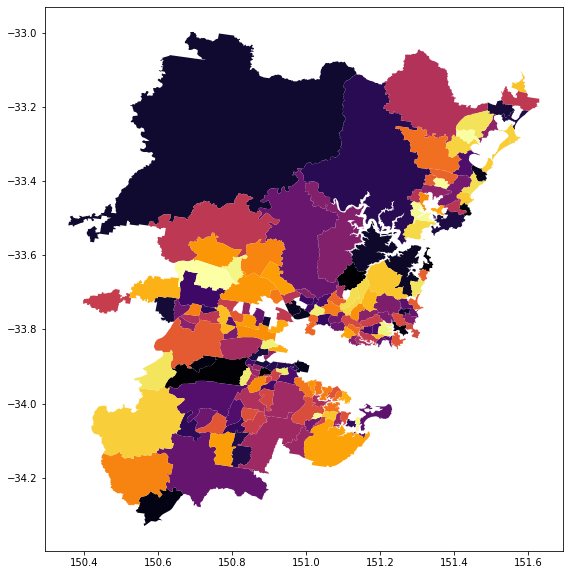

In [60]:

retdf[['scores','geom']].plot(cmap='inferno',figsize=(10, 10))
plt.show()


Scatter Plots and subsequent correlation analysis was run for bushfire risk score and affluence factors. Bushfire risk is on the horizontal axis and the affluence factors on the vertical.

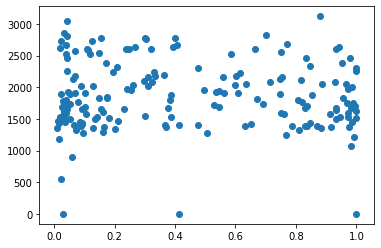

In [46]:
import matplotlib.pyplot as plt

plt.scatter(retdf['scores'],retdf['avg_monthly_rent'])
plt.show()

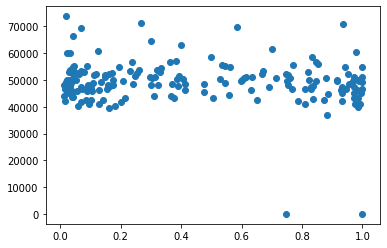

In [47]:
plt.scatter(retdf['scores'],retdf['median_annual_household_income'])
plt.show()

In [48]:
import numpy as np

print('correlation with income:',np.corrcoef(retdf['scores'],retdf['median_annual_household_income'])[0][1])
print('correlation with rent:',np.corrcoef(retdf['scores'],retdf['avg_monthly_rent'])[0][1])

correlation with income: -0.14324408497618835
correlation with rent: -0.037788864692920525


### Linear Regression
Finally, a Multifactor Linear Regression Analysis was run and a predictive model was created to ascertain bushfire risk based on a number of key factors.

In [62]:
# Linear Regression Code

import pandas as pd
from sklearn import linear_model
import statsmodels.api as sm

# separating our input and output variables for the linear model
X = retdf[['population', 'dwelling_and_business', 'assistive_services', 'bfpl_area', 'exposed_area', 'fires']]
Y = retdf['scores']

# initializing and training the regression
regr = linear_model.LinearRegression()
regr.fit(X, Y)

# displaying results
print('Intercept: \n', regr.intercept_)
print('Coefficients: \n', regr.coef_)

# Prediction Example: Woronora Heights
Popu = 1.201848e+07
Dwel = 4.293480e+06
Assi = 35915.044323
Bfpl = 57.871727
Expo = 1.111020e+10
Fire = 0

# returning our 
def predict(pop,dwe,ass,bfpl,exp,fire):
    if regr.predict([[pop,dwe,ass,bfpl,exp,fire]])>1:
        return 1
    elif regr.predict([[pop,dwe,ass,bfpl,exp,fire]])<0:
        return 0
    else:
        return regr.predict([[pop,dwe,ass,bfpl,exp,fire]])
woronora = predict(Popu, Dwel, Assi, Bfpl, Expo, Fire)

print ('Predicted Bushfire Risk: \n', woronora)

Intercept: 
 -0.0947562881780405
Coefficients: 
 [ 1.82944049e-08  2.14398934e-08 -1.64295190e-06  2.40191812e-02
  1.09928018e-11  9.20710511e-01]
Predicted Bushfire Risk: 
 1


In [50]:
conn.close()
db.dispose()